In [1]:
%%capture
import operator

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import importlib as imp

from collections import namedtuple
from random import sample, shuffle
from functools import reduce
from itertools import accumulate
from math import floor, ceil, sqrt, log, pi
from matplotlib import pyplot as plt
from tensorflow.keras import layers, utils, losses, models as mds, optimizers

if imp.util.find_spec('aggdraw'): import aggdraw
if imp.util.find_spec('tensorflow_addons'): from tensorflow_addons import layers as tfa_layers
if imp.util.find_spec('tensorflow_models'): from official.vision.beta.ops import augment as visaugment
if imp.util.find_spec('tensorflow_probability'): from tensorflow_probability import distributions as tfd
if imp.util.find_spec('keras_tuner'): import keras_tuner as kt

In [2]:
# Dataset image size
IMG_SIZE = 264
N_CLASSES = 102

def preprocess(image, *args):
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    image /= 255
    return (image, *args)

train_ds, val_ds = tfds.load(
    'oxford_flowers102',
    split=['train', 'validation'],
    as_supervised=True,
    read_config=tfds.ReadConfig(try_autocache=False)
)

train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-09-09 14:00:51.770484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-09 14:00:51.770622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def create_model(lr=0.001):
    m = tf.keras.Sequential([
        layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPool2D(2),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPool2D(2),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPool2D(2),
        layers.Flatten(),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Nadam(lr)
    m.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics='accuracy')

    return m

def create_with_params(lr):
    return create_model(lr)

## Random Search

In [4]:
def build_model_with_hp():
    def build_model(hp):
        lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        bs = hp.Choice('bs', [8, 16, 24, 32])
        m = create_with_params(lr=lr)

        return m
    
    return build_model

class RandomSearchWithBatch(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        augs = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
        ])
        print(trial.hyperparameters.values)
        train_ds = args[0]
        val_ds = kwargs.get('validation_data')
        batch_size = trial.hyperparameters['bs']

        tds = train_ds.shuffle(batch_size*20, reshuffle_each_iteration=True).batch(batch_size)
        tds = tds.map(lambda x,y: (augs(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).take(1)
        vds = val_ds.batch(batch_size).cache().take(1) if val_ds else None

        # Update Trial Arguments
        args = tds, *args[1:]
        kwargs['validation_data'] = vds

        return super(RandomSearchWithBatch, self).run_trial(trial, *args, **kwargs)

# Tune Hyper Parameters
tuner = RandomSearchWithBatch(build_model_with_hp(), objective='val_loss', max_trials=7)
tuner.search(train_ds, epochs=10, validation_data=val_ds)

# Select best parameters
model = tuner.get_best_models()[0]
BATCH_SIZE = tuner.get_best_hyperparameters()[0]['bs']
tuner.results_summary()
tuner.get_best_hyperparameters()[0].values

Trial 1 Complete [00h 00m 14s]
val_loss: 4.6880927085876465

Best val_loss So Far: 4.6880927085876465
Total elapsed time: 00h 00m 14s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
0.0028644         |0.00035276        |lr
24                |24                |bs

{'lr': 0.002864353203357012, 'bs': 24}
Epoch 1/10


2022-09-09 14:00:22.512261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 14:00:22.578565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 14:00:22.947831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 4.6314 - accuracy: 0.0000e+00

2022-09-09 14:00:24.975983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 4.6314 - accuracy: 0.0000e+00 - val_loss: 8.2313 - val_accuracy: 0.0417


2022-09-09 14:00:25.177673: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/10


2022-09-09 14:00:25.402538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 9.9318 - accuracy: 0.0000e+00 - val_loss: 4.7376 - val_accuracy: 0.0000e+00


2022-09-09 14:00:27.224948: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3/10


2022-09-09 14:00:27.444510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 4.9197 - accuracy: 0.0417 - val_loss: 4.6461 - val_accuracy: 0.0000e+00


2022-09-09 14:00:28.423045: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-09 14:00:28.605844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 4.7759 - accuracy: 0.0000e+00 - val_loss: 4.5756 - val_accuracy: 0.0000e+00


2022-09-09 14:00:29.578006: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-09 14:00:29.734131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 5/10


: 

: 

## Bayesian Optimization

In [6]:
def build_model_with_hp():
    def build_model(hp):
        lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        bs = hp.Choice('bs', [8, 16, 24, 32])
        m = create_with_params(lr=lr)

        return m
    
    return build_model

class BayesianOptimizationWithBatch(kt.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        augs = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
        ])
        print(trial.hyperparameters.values)
        train_ds = args[0]
        val_ds = kwargs.get('validation_data')
        batch_size = trial.hyperparameters['bs']

        tds = train_ds.shuffle(batch_size*20, reshuffle_each_iteration=True).batch(batch_size)
        tds = tds.map(lambda x,y: (augs(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).take(1)
        vds = val_ds.batch(batch_size).cache().take(1) if val_ds else None

        # Update Trial Arguments
        args = tds, *args[1:]
        kwargs['validation_data'] = vds

        return super(BayesianOptimizationWithBatch, self).run_trial(trial, *args, **kwargs)

# Tune Hyper Parameters
tuner = BayesianOptimizationWithBatch(build_model_with_hp(), objective='val_loss', max_trials=7, project_name='bayesian')
tuner.search(train_ds, epochs=10, validation_data=val_ds)

# Select best parameters
model = tuner.get_best_models()[0]
BATCH_SIZE = tuner.get_best_hyperparameters()[0]['bs']
tuner.results_summary()
tuner.get_best_hyperparameters()[0].values

Trial 7 Complete [00h 00m 16s]
val_loss: 4.633131980895996

Best val_loss So Far: 4.519103050231934
Total elapsed time: 00h 01m 59s
Results summary
Results in ./bayesian
Showing 10 best trials
Trial summary
Hyperparameters:
lr: 0.0015338120284119725
bs: 32
Score: 4.519103050231934
Trial summary
Hyperparameters:
lr: 0.0007078536645991944
bs: 32
Score: 4.56817626953125
Trial summary
Hyperparameters:
lr: 0.001961600367042234
bs: 32
Score: 4.597342014312744
Trial summary
Hyperparameters:
lr: 0.0011360464630244373
bs: 32
Score: 4.604775428771973
Trial summary
Hyperparameters:
lr: 0.01
bs: 32
Score: 4.615253925323486
Trial summary
Hyperparameters:
lr: 0.0001
bs: 32
Score: 4.633131980895996
Trial summary
Hyperparameters:
lr: 0.0003967960974673944
bs: 24
Score: 4.77764892578125


{'lr': 0.0015338120284119725, 'bs': 32}

In [39]:
tuner.oracle.trials[str(0)].hyperparameters['lr']

0.0003967960974673944

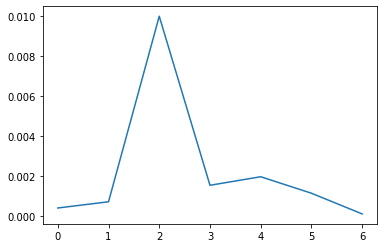

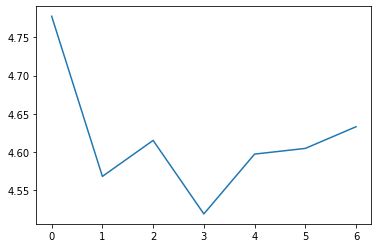

In [45]:
learning_rates = []
scores = []

for tid in range(tuner.oracle.max_trials):
    learning_rates.append(tuner.oracle.trials[str(tid)].hyperparameters['lr'])
    scores.append(tuner.oracle.trials[str(tid)].score)

plt.plot(range(tuner.oracle.max_trials), learning_rates)
plt.figure()
plt.plot(range(tuner.oracle.max_trials), scores)
